In [2]:
import pandas as pd
import numpy as np

In [3]:
# get all of the relevant data frames
songDate = pd.read_csv('uniqueSongArtistDate.csv')
wordVecFeatures = pd.read_csv('wordVecFeatures.csv')
songMetaData= pd.read_csv('songMetadata.csv',encoding = "ISO-8859-1")
pca_dtm = pd.read_csv('pca_dtm.csv')
lda_top = pd.read_csv('ldaTop.csv')

In [ ]:
songMetaData

In [4]:
songDate['Date'] = pd.to_datetime(songDate['Date'])
songDate = songDate.drop(['URL','Unnamed: 0'],1)

In [5]:
# join everything to Train DF and then cluster!!
fullFeatureIndSong = songDate.merge(wordVecFeatures,on=['Track Name','Artist'])

In [6]:
fullFeatureIndSong = fullFeatureIndSong.merge(songMetaData,on=['Track Name','Artist'])

In [7]:
fullFeatureIndSong = fullFeatureIndSong.merge(pca_dtm,on=['Track Name','Artist'])

In [8]:
fullFeatureIndSong = fullFeatureIndSong.merge(lda_top,on=['Track Name','Artist'])

In [9]:
for ind,c in fullFeatureIndSong.isnull().sum().iteritems():
    if c > 0:
        print(ind,c)

In [ ]:
fullFeatureIndSong.isnull().sum()

In [53]:
type(fullFeatureIndSong.isnull().sum())

pandas.core.series.Series

In [11]:
# split into training and testing
# params to split by time
trainBefore = '2017-10-01' # can change
trainDf = fullFeatureIndSong[fullFeatureIndSong['Date']<= trainBefore]
testDf = fullFeatureIndSong[fullFeatureIndSong['Date']> trainBefore]

In [12]:
trainDf

,Track Name,Artist,Position,Streams,Date,Region,Unnamed: 0_x,Unnamed: 0.1,art_feat_0,art_feat_1,...,pca_feat_298,pca_feat_299,Unnamed: 0_y,love,Uncertainty,Explictives,German,Swedish,Dutch,Spanish
0,Bad and Boujee (feat. Lil Uzi Vert),Migos,1,1371493,2017-01-01,us,0,0,-0.000710,-0.001311,...,1.096351,-1.163444,0,0,0,1,0,0,0,0
1,Fake Love,Drake,2,1180074,2017-01-01,us,1,1,0.001028,0.000467,...,1.227985,0.612555,1,0,1,0,0,0,0,0
2,Starboy,The Weeknd,3,1064351,2017-01-01,us,2,2,0.001684,0.001790,...,-0.175895,-0.263147,2,0,1,0,0,0,0,0
3,Closer,The Chainsmokers,4,1010492,2017-01-01,us,3,3,0.000964,0.002493,...,-0.174602,0.570201,3,0,1,0,0,0,0,0
4,Black Beatles,Rae Sremmurd,5,874289,2017-01-01,us,4,4,0.001830,-0.000981,...,-0.527415,-0.680256,4,0,1,0,0,0,0,0
5,Broccoli (feat. Lil Yachty),DRAM,6,763259,2017-01-01,us,5,5,-0.000777,0.000777,...,-0.736414,0.941844,5,0,1,0,0,0,0,0
6,One Dance,Drake,7,753150,2017-01-01,us,6,6,0.001028,0.000467,...,0.109089,-0.183574,6,0,1,0,0,0,0,0
7,Let Me Love You,DJ Snake,9,690483,2017-01-01,us,8,8,0.001192,-0.000554,...,0.123938,-0.577541,8,1,0,0,0,0,0,0
8,Bounce Back,Big Sean,10,682688,2017-01-01,us,9,9,-0.001939,-0.001753,...,-0.119975,0.213018,9,0,1,0,0,0,0,0
9,I Feel It Coming,The Weeknd,11,651807,2017-01-01,us,10,10,0.001684,0.001790,...,-0.349509,0.386367,10,1,0,0,0,0,0,0


In [13]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [14]:
train_mat = trainDf[trainDf.columns[8:]].values
test_mat = testDf[trainDf.columns[8:]].values

In [15]:
mms = StandardScaler()

In [29]:
train_mat_norm = mms.fit_transform(train_mat)
test_mat_norm = mms.transform(test_mat)

In [ ]:
train_mat_norm

In [30]:
from sklearn.decomposition import PCA
comp = 50
pca_model = PCA(n_components = comp)

In [31]:
pca_fitmod = pca_model.fit(train_mat_norm)

In [32]:
variance = pca_fitmod.explained_variance_ratio_ #calculate variance ratios                                        
cv=np.cumsum(np.round(pca_model.explained_variance_ratio_,decimals=3)*100)

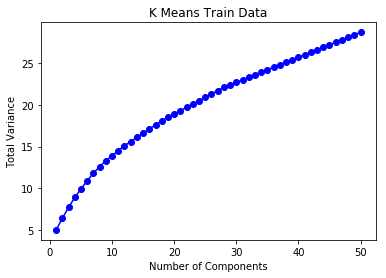

In [33]:
plt.plot(range(1,comp+1),cv, c='blue', marker='o')
plt.title('K Means Train Data')
plt.ylabel('Total Variance')
plt.xlabel('Number of Components')
#plt.show()
plt.savefig('VarianceDTM.png')

In [34]:
pca_model = PCA(n_components = 25)
pca_fitmod = pca_model.fit(train_mat)
pca_train = pca_fitmod.fit_transform(train_mat)
pca_test = pca_model.transform(test_mat)

## KMEANS With PCA Data

In [22]:
from sklearn.cluster import KMeans

In [23]:
# X can still be used
def KMeansTest(data):
    res = []
    for i in range(1,11):
        km = KMeans(i,'random', max_iter=300, random_state=0, n_init=30)
        km_fit = km.fit(data)
        res.append(km_fit.inertia_)
    return res

In [24]:
distortion = KMeansTest(pca_train)

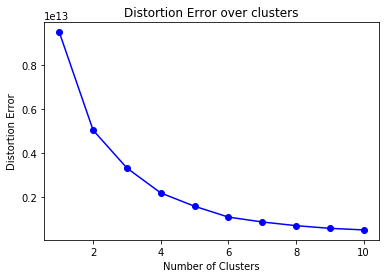

In [25]:
plt.plot(range(1,11),distortion, c='blue', marker='o')
plt.title('Distortion Error over clusters')
plt.ylabel('Distortion Error')
plt.xlabel('Number of Clusters')
plt.savefig('DistortionErr.png')

In [35]:
#2 is the magic number
km = KMeans(2,'random', max_iter=300, random_state=0, n_init=30)
km_fit = km.fit(pca_train)
train_pred_label = km_fit.labels_

In [36]:
test_pred_label = km_fit.predict(pca_test)

In [180]:
##update train and test 
train_mat_norm_class = np.append(train_mat_norm,np.transpose(np.matrix(train_pred_label)),1)
test_mat_norm_class = np.append(test_mat_norm,np.transpose(np.matrix(test_pred_label)),1)

In [194]:
def getClassCol(mat,cl):
    return np.squeeze(np.asarray(mat[:,-1] == cl))
    

In [204]:
## Time to split these up into groups and online learn
#train_c0 = train_mat_norm_class[getClassCol(train_mat_norm_class,0),:-1]
# test_c0 = test_mat_norm_class[getClassCol(test_mat_norm_class,0),:-1]

In [ ]:
trainDf['Clabel'] = train_pred_label
testDf['Clabel'] = test_pred_label

In [46]:
trainPCADf = pd.concat([trainDf[['Artist','Track Name']].reset_index(drop=True),pd.DataFrame(pca_train)],1)
trainPCADf['Clabel'] = train_pred_label
testPCADf = pd.concat([testDf[['Artist','Track Name']].reset_index(drop=True),pd.DataFrame(pca_test)],1)
testPCADf['Clabel'] = test

,Artist,Track Name,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,Migos,Bad and Boujee (feat. Lil Uzi Vert),125070.374057,-7507.720515,-363.142247,5.285858,-3.155895,-1.672589,0.266080,-2.207203,...,0.712162,-2.529469,-2.304393,-5.635395,0.798658,6.117505,5.126683,1.590143,-4.771314,-2.032453
1,Drake,Fake Love,-7141.783367,-7058.820634,-509.178837,11.718530,-3.567760,-1.057073,-1.285202,-1.653581,...,-4.182009,-5.947473,2.185383,0.724161,-0.389675,-1.193460,0.293319,0.815748,-1.394979,-0.925897
2,The Weeknd,Starboy,12374.101752,-7122.090273,-487.207202,63.745663,-1.702421,-1.441274,-2.393195,1.566785,...,1.089672,-0.815153,0.288159,-1.241207,-1.295304,0.196528,-1.355274,0.527983,0.385253,-0.095712
3,The Chainsmokers,Closer,26881.018364,-7168.439218,-470.475012,-27.272424,-2.115991,-1.034487,-3.123394,1.038044,...,0.369415,1.644935,-1.460706,1.533031,-0.170413,-0.374292,3.278330,0.302482,-0.398746,-0.849101
4,Rae Sremmurd,Black Beatles,73813.730709,-7324.256550,-418.192352,23.750859,-2.058181,-1.257518,-2.474937,-0.138369,...,-5.113616,-2.174675,-0.239585,1.943871,2.832205,-1.978431,0.858746,1.255826,-1.430097,-0.240531
5,DRAM,Broccoli (feat. Lil Yachty),7126.160030,-7096.544197,-491.691097,23.783722,-2.284540,-1.300068,0.884042,-1.758387,...,-2.569002,0.822157,-3.219509,0.585612,0.613784,0.046954,1.447584,0.721895,-0.156991,-0.218536
6,Drake,One Dance,-44091.508674,-6921.039315,-547.856733,-18.357288,-2.459692,-0.722640,-1.892108,-0.111146,...,2.232979,1.015387,-0.007460,0.835403,0.600657,-0.571740,0.123455,0.288201,-0.657511,0.217247
7,DJ Snake,Let Me Love You,-12131.693621,-7023.707792,-511.811689,77.461093,-1.849163,-1.107935,-1.261722,1.163257,...,-1.321907,1.367281,-0.795442,0.562088,0.113508,0.369651,1.961824,0.772795,-2.276189,-0.260343
8,Big Sean,Bounce Back,4281.211084,-7076.489492,-492.918560,-40.781378,-2.666246,-0.922009,-2.585678,-0.382755,...,-2.671306,-2.892488,0.543235,1.167575,1.887708,-2.039585,-0.635373,1.228983,-0.358920,-0.340407
9,The Weeknd,I Feel It Coming,51107.924027,-7231.942118,-440.658409,-29.369345,-3.668022,-1.551499,-1.523822,-1.115567,...,4.254021,0.919566,1.867676,3.480080,1.474199,-4.985186,-3.805195,1.089192,2.402259,0.536733


## Data Preparation

In [212]:
dateStream = pd.read_csv('songRegionStreams.csv')
dateStream = dateStream.drop(['Unnamed: 0'],1)

In [218]:
dateStream = pd.concat([dateStream,pd.get_dummies(dateStream.Region)],1).drop('Region',1)
dateStream['Date'] = pd.to_datetime(dateStream.Date)

In [ ]:
trainStream = dateStream.merge(trainDf,on=['Track Name','Artist'])

In [ ]:
trainStream

## Online Learning

In [200]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPRegressor

In [202]:
# try one model on one class
percepModel = Perceptron(max_iter=300)